# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 6
# Reg-Logistic Regression, ROC, and Data Imputation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error

from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline

## Automated Breast Cancer Detection

In this homework, we will consider the problem of early breast cancer detection from X-ray images. Specifically, given a candidate region of interest (ROI) from an X-ray image of a patient's breast, the goal is to predict if the region corresponds to a malignant tumor (label 1) or is normal (label 0). The training and test data sets for this problem is provided in the file `hw6_dataset.csv`. Each row in these files corresponds to a ROI in a patient's X-ray, with columns 1-117 containing features computed using standard image processing algorithms. The last column contains the class label, and is based on a radiologist's opinion or a biopsy. This data was obtained from the KDD Cup 2008 challenge.

The data set contain a total of 102,294 candidate ROIs, of which only 623 are malignant, while the remaining are all normal. 



## Question 1: Beyond Classification Accuracy


0.  Split the data set into a training set and a testing set.  The training set should be 75% of the original data set, and the testing set 25%.  Use `np.random.seed(9001)`.

1. Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation. 
    1. How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients? 
    2. Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?
    
For applications with imbalanced class labels, in this case when there are many more healthy subjects ($Y=0$) than those with cancer ($Y=1$), the classification accuracy may not be the best metric to evaluate a classifier's performance. As an alternative, we could analyze the confusion table for the classifier. 

<ol start="3">
<li> Compute the confusion table for both the fitted classifier and the classifier that predicts all 0's.</li>
<li> Using the entries of the confusion table compute the *true positive rate* and the *true negative rate* for the two classifiers. Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.</li>
<li> What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?</li>
</ol>
*Hint:* You may use the `metrics.confusion_matrix` function to compute the confusion matrix for a classification model.

### Question 1 Solutions:


**1\. Split the data set into a training set and a testing set.  The training set should be 75% of the original data set, and the testing set 25%.  Use `np.random.seed(9001)`.**


In [2]:
df = pd.read_csv('HW6_dataset.csv', header=0, names=list(range(1,118)) + ['type'])

np.random.seed(9001)
msk = np.random.rand(len(df)) < 0.75
data_train = df[msk]
data_test = df[~msk]

X_train = data_train.loc[:, data_train.columns != 'type']
y_train = data_train['type']
X_test = data_test.loc[:, data_test.columns != 'type']
y_test = data_test['type']

**2\. Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation.**
    1. How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients?
    2. Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?

In [3]:
logregcv = LogisticRegressionCV(random_state = 123) # By default LBGFS induces L2 norm.
logregcv.fit(X_train, y_train)
y_hat_train = logregcv.predict(X_train)
y_hat_test = logregcv.predict(X_test)
print("Train accuracy: ", accuracy_score(y_train, y_hat_train))
print("Test accuracy: ", accuracy_score(y_test, y_hat_test))

Train accuracy:  0.995462323829
Test accuracy:  0.995084269663


In [4]:
print("Train accuracy: ", accuracy_score(y_train, [0 for y in y_train]))
print("Test accuracy: ", accuracy_score(y_test, [0 for y in y_test]))

Train accuracy:  0.994135630372
Test accuracy:  0.993913857678


The fitted model does barely better than on a model that predicts normal on all patients, so no. 

**3\. Compute the confusion table for both the fitted classifier and the classifier that predicts all 0's.**

In [5]:
conf_mat = confusion_matrix(y_test, y_hat_test)
conf_df = pd.DataFrame(conf_mat, columns = ['y_hat=0', 'y_hat = 1'], index = ['y=0', 'y=1'])
conf_df

,y_hat=0,y_hat = 1
y=0,16976,8
y=1,76,28


In [6]:
conf_mat_naive = confusion_matrix(y_test, [0 for y in y_test])
conf_df_naive = pd.DataFrame(conf_mat_naive, columns = ['y_hat=0', 'y_hat = 1'], index = ['y=0', 'y=1'])
conf_df_naive

,y_hat=0,y_hat = 1
y=0,16984,0
y=1,104,0


**4\. Using the entries of the confusion table compute the *true positive rate* and the *true negative rate* for the two classifiers. Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.**

In [7]:
print("True Positive Rate for Fitted: ", float(conf_mat[1][1])/(conf_mat[1][1]+ conf_mat[1][0]))
print("True Negative Rate for Fitted: ", float(conf_mat[0][0])/(conf_mat[0][0] + conf_mat[0][1]))

True Positive Rate for Fitted:  0.269230769231
True Negative Rate for Fitted:  0.999528968441


In [8]:
print("True Positive Rate for Naive: ", float(conf_mat_naive[1][1])/(conf_mat_naive[1][1]+ conf_mat_naive[1][0]))
print("True Negative Rate for Naive: ", float(conf_mat_naive[0][0])/(conf_mat_naive[0][0] + conf_mat_naive[0][1]))

True Positive Rate for Naive:  0.0
True Negative Rate for Naive:  1.0


For the ones with all zeros, we never get any false positives. However, the number of false negatives increase, which is fundamentally bad as that means there are people with cancer who are told they do not, and hence they may not seek proper treatment. 

**5\. What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?**

In [9]:
print("False Positive Rate for Fitted: ", float(conf_mat[0][1])/(conf_mat[0][1] + conf_mat[0][0]))

False Positive Rate for Fitted:  0.000471031559114


TNR + FPR = 1 for the first part, but there is NO good relation for the FPR and the TPR as they cannot be used to predict each other. 

## Question 2: ROC Analysis

Another powerful diagnostic tool for class-imbalanced classification tasks is the Receiver Operating Characteristic (ROC) curve. Notice that the default logistic regression classifier in `sklearn` classifies a data point by thresholding the predicted class probability $\hat{P}(Y=1)$ at 0.5. By using a different threshold, we can adjust the trade-off between the true positive rate (TPR) and false positive rate (FPR) of the classifier. The ROC curve allows us to visualize this trade-off across all possible thresholds.


1. Display the ROC curve for the fitted classifier on the *test set*. In the same plot, also display the ROC curve for the all 0's classifier. How do the two curves compare?

2.  Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.
    - FPR = 0
    - FPR = 0.1
    - FPR = 0.5
    - FPR = 0.9
- Suppose a clinician told you that diagnosing a cancer patient as normal is *twice* as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold? 

- Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)? 

*Hint:* You may use the `metrics.roc_curve` function to compute the ROC curve for a classification model and the `metrics.roc_auc_score` function to compute the AUC for the model.

### Question 2 Solutions:

**1\. Display the ROC curve for the fitted classifier on the *test set*. In the same plot, also display the ROC curve for the all 0's classifier. How do the two curves compare?**


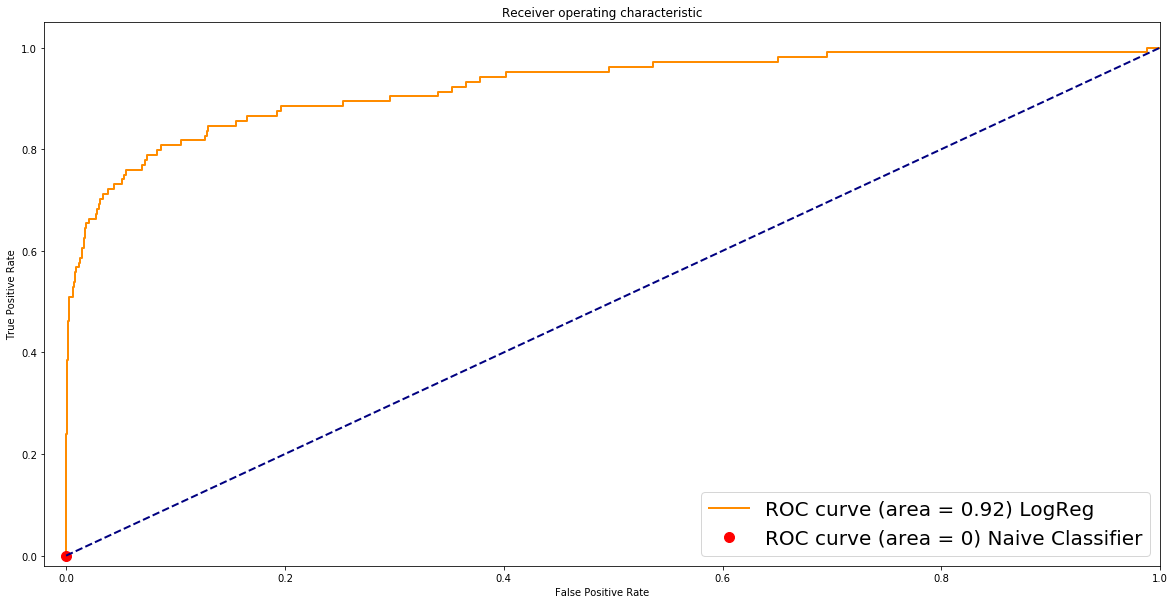

In [29]:
preds = logregcv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
fpr_2, tpr_2, thresholds_2 = metrics.roc_curve(y_test, [0 for y in y_test])
roc_auc_2 = metrics.auc(fpr_2, tpr_2)
plt.figure(figsize=(20,10))
lw = 2
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f) LogReg' % roc_auc)
plt.plot([0], [0], marker='o', markersize=10, lw = 0, color="red", label ='ROC curve (area = 0) Naive Classifier')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([-0.02, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", prop={'size':20})
plt.show()

Ideally, we want the area under the ROC curve to be 1. We would like the curve to rise very fast and to capture as much of the top left area as we can. The ROC curve for all 0's indicates that we are doing no better than random sampling, or tossing a coin. 

**2\.  Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.**
    - FPR = 0
    - FPR = 0.1
    - FPR = 0.5
    - FPR = 0.9

In [30]:
print(tpr[np.min([i for i, x in enumerate(fpr) if x>=0])], thresholds[np.min([i for i, x in enumerate(fpr) if x>=0])])
print(tpr[np.min([i for i, x in enumerate(fpr) if x>=0.1])], thresholds[np.min([i for i, x in enumerate(fpr) if x>=0.1])])
print(tpr[np.min([i for i, x in enumerate(fpr) if x>=0.5])], thresholds[np.min([i for i, x in enumerate(fpr) if x>=0.5])])
print(tpr[np.min([i for i, x in enumerate(fpr) if x>=0.9])], thresholds[np.min([i for i, x in enumerate(fpr) if x>=0.9])])

0.0 1.99990555727
0.807692307692 0.00571130223307
0.961538461538 0.000152201711086
0.990384615385 6.32310417421e-09


As our threshold increases, the true positive rate decreases dramatically. As our threshold goes to zero, we will be predicting 1's for everything. As a result, our true positive rate will be very high. As our threshold decreases, the FPR increases, and so does the TPR. 

**3\. Suppose a clinician told you that diagnosing a cancer patient as normal is *twice* as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold?**

Since it would be twice as important to increase TPR, we would want a combined metric that weights a higher TPR more. 

Combined metric = 2*TPR + (1-FPR) and we want to maximize this combined rate. 

In [31]:
new_metric  = [2*tpr[i]+(1-fpr[i]) for i in range(len(fpr))]
new_metric2 = [(1-tpr[i])-(0.5*fpr[i]) for i in range(len(fpr))]
np.argmin(new_metric2)

157

By finding the argmax of the values of our metric, we can compute the threshold as 0.00202226.

In [32]:
thresholds[np.argmax(new_metric)]

0.0020222606920528977

Then we can find the FPR and the TPR of the classifier at this threshold.

In [33]:
print('True Positive Rate: ', tpr[126])
print('False Positive Rate: ', fpr[126])

True Positive Rate:  0.884615384615
False Positive Rate:  0.196066886481


**4\. Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)?** 

In [34]:
print('Area under the ROC Curve for Fitted Classifer: ', roc_auc)
print('Area under the ROC Curve for Naive 0 Classifier: ', roc_auc_2)

Area under the ROC Curve for Fitted Classifer:  0.923302814414
Area under the ROC Curve for Naive 0 Classifier:  0.5


The area under the curve is a metric used for classification accuracy. It is a better metric for comparing models in our case. In the logistic regression model, our fitted model had an accuracy score of 0.995084269663 vs. the naive all 0's model of 0.993913857678. In this ROC with the AUC metric approach, we see a much bigger difference from 0.9233028144 to 0.5. Hence, AUC is better able to distinguish between two models based on two metrics alone. The AUC takes into account the true positive and false positive rates as well, instead of just the general accuracy rate.

## Question 3: Missing data

In this problem you are given a different data set, `HW6_dataset_missing.csv`, that is  similar to the one you used above (same column definitions and same conditions), however this data set contains missing values. 

1. Remove all observations that contain any missing values, split the dataset into a 75-25 train-test split, and fit the regularized logistic regression as in Question 1 (use `LogisticRegressionCV` again to retune).  Report the overall classification rate and TPR in the test set.
2. Restart with a fresh copy of the data in `HW6_dataset_missing.csv` and impute the missing data via mean imputation.  Split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
3. Again restart with a fresh copy of the data in `HW6_dataset_missing.csv` and impute the missing data via a model-based imputation method. Once again split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
4. Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.



The following code creates the necessary data sets for ALL of the first 3 problems. 

In [35]:
df2_missing = pd.read_csv('HW6_dataset_missing.csv', header=0, names=list(range(1,118)) + ['type'])
df2_missing2 = df2_missing.copy()
df3_missing3 = df2_missing.copy()

# Problem 1 DROP ALL NAN 
df2_missing.dropna(inplace=True)
# SPLIT THE DATA INTO TRAIN/TEST
np.random.seed(9001)
msk = np.random.rand(len(df2_missing)) < 0.75
data_train = df2_missing[msk]
data_test = df2_missing[~msk]

X_train = data_train.loc[:, data_train.columns != 'type']
y_train =data_train['type']
X_test= data_test.loc[:, data_test.columns != 'type']
y_test =data_test['type']
# data_train, data_test are for Problem 1

# Problem 2 DO NOT DROP BUT IMPUTE WITH MEAN
values = df2_missing2.values
imputer = Imputer( strategy='mean')
df2_missing2 = imputer.fit_transform(values)
msk = np.random.rand(len(df2_missing2)) < 0.75
data_train2 = df2_missing2[msk]
data_test2 = df2_missing2[~msk]

X_train2 = data_train2[:, 0:-1]
y_train2 =data_train2[:, -1]
X_test2 = data_test2[:, 0:-1]
y_test2 =data_test2[:, -1]
# data_train2, data_test2 are for Problem 2


# Problem 3 DO NOT DROP BUT IMPUTE WITH LINEAR REGRESSION
cols_full = []
cols_missing = []
for i in range(df3_missing3.shape[1] - 1):
    if sum(df3_missing3.iloc[:, i].isnull()) > 0:
        cols_missing.append(i)
    else:
        cols_full.append(i)

full_data_x = df3_missing3.iloc[:, cols_full]
full_data_y = df3_missing3['type']

for i in cols_missing:

    #rows where column i need to be imputed
    pred_x = full_data_x[df3_missing3.iloc[:,i].isnull()]

    #rows can be used for prediction
    reg_x = full_data_x[~df3_missing3.iloc[:,i].isnull()]
    reg_y = full_data_y[~df3_missing3.iloc[:,i].isnull()]
    
    #Linear regression model based on full columns
    regress = LinearRegression().fit(reg_x, reg_y)
    reg_y_hat = regress.predict(reg_x)
    y_hat = regress.predict(pred_x)
    y_hat_noise = y_hat + np.random.normal(loc=0, scale = np.sqrt(mean_squared_error(reg_y, reg_y_hat)), size = y_hat.shape[0])
    
    missing_series = pd.Series(data=y_hat_noise, index=df3_missing3.iloc[:,i][df3_missing3.iloc[:,i].isnull()].index)
    df3_missing3.iloc[:,i] = df3_missing3.iloc[:,i].fillna(missing_series)

msk = np.random.rand(len(df3_missing3)) < 0.75
data_train3 = df3_missing3[msk]
data_test3 = df3_missing3[~msk]

X_train3 = data_train3.loc[:, data_train3.columns != 'type']
y_train3 =data_train3['type']
X_test3= data_test3.loc[:, data_test3.columns != 'type']
y_test3 =data_test3['type']
# data_train3, data_test3 are for Problem 3


**1\. Remove all observations that contain any missing values, split the dataset into a 75-25 train-test split, and fit the regularized logistic regression as in Question 1 (use `LogisticRegressionCV` again to retune).  Report the overall classification rate and TPR in the test set.**

In [36]:
# Problem 1
logregcv = LogisticRegressionCV()
logregcv.fit(X_train, y_train)
y_hat_train = logregcv.predict(X_train)
y_hat_test = logregcv.predict(X_test)
print("Train accuracy for Problem 1: ", accuracy_score(y_train, y_hat_train))
print("Test accuracy for Problem 1: ", accuracy_score(y_test, y_hat_test))

Train accuracy for Problem 1:  0.999074074074
Test accuracy for Problem 1:  0.994382022472


/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


We now create the confusion matrix.

In [37]:
# Problem 1 
conf_mat_1 = confusion_matrix(y_test, y_hat_test)
conf_df_1 = pd.DataFrame(conf_mat_1, columns = ['y_hat=0', 'y_hat = 1'], index = ['y=0', 'y=1'])
conf_df_1

,y_hat=0,y_hat = 1
y=0,354,0
y=1,2,0


In [38]:
print("True Positive Rate for Part 1: ", float(conf_mat_1[1][1])/(conf_mat_1[1][1]+ conf_mat_1[1][0]))

True Positive Rate for Part 1:  0.0


**2\. Restart with a fresh copy of the data in `HW6_dataset_missing.csv` and impute the missing data via mean imputation.  Split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.** 

In [39]:
logregcv = LogisticRegressionCV()
logregcv.fit(X_train2, y_train2)
y_hat_train2 = logregcv.predict(X_train2)
y_hat_test2 = logregcv.predict(X_test2)
print("train accuracy for Problem 2: ", accuracy_score(y_train2, y_hat_train2))
print("test accuracy for Problem 2: ", accuracy_score(y_test2, y_hat_test2))

train accuracy for Problem 2:  0.994751908397
test accuracy for Problem 2:  0.99511002445


We now create the confusion matrix for Problem 2. 

In [40]:
#Problem 2
conf_mat_2 = confusion_matrix(y_test2, y_hat_test2)
conf_df_2 = pd.DataFrame(conf_mat_2, columns = ['y_hat=0', 'y_hat = 1'], index = ['y=0', 'y=1'])
conf_df_2

,y_hat=0,y_hat = 1
y=0,6102,2
y=1,28,3


In [41]:
print("True Positive Rate for Part 2: ", float(conf_mat_2[1][1])/(conf_mat_2[1][1]+ conf_mat_2[1][0]))

True Positive Rate for Part 2:  0.0967741935484


**3\. Again restart with a fresh copy of the data in `HW6_dataset_missing.csv` and impute the missing data via a model-based imputation method. Once again split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.**

In [42]:
logregcv = LogisticRegressionCV()
logregcv.fit(X_train3, y_train3)
y_hat_train3 = logregcv.predict(X_train3)
y_hat_test3 = logregcv.predict(X_test3)
print("train accuracy for Problem 3: ", accuracy_score(y_train3, y_hat_train3))
print("test accuracy for Problem 3: ", accuracy_score(y_test3, y_hat_test3))

train accuracy for Problem 3:  0.994414596521
test accuracy for Problem 3:  0.996129032258


In [43]:
conf_mat_3 = confusion_matrix(y_test3, y_hat_test3)
conf_df_3 = pd.DataFrame(conf_mat_3, columns = ['y_hat=0', 'y_hat = 1'], index = ['y=0', 'y=1'])
conf_df_3

,y_hat=0,y_hat = 1
y=0,6168,1
y=1,23,8


In [44]:
print("True Positive Rate for Part 3: ", float(conf_mat_3[1][1])/(conf_mat_3[1][1]+ conf_mat_3[1][0]))

True Positive Rate for Part 3:  0.258064516129


**4\. Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.**

The result with dropping all NA values results in the lowest TPR, with the mean method giving the second best TPR result, and finally, the imputation method with Linear Regression yields the best. The computational complexity of the linear regression model is the highest, as we need to fit a model for each NA value, while in the mean method it was just computing a mean across values. The NA method is the lowest complexity as it just involves dropping values. 

We expect to see the higher TPR from Imputation using Linear regression model since it provides a more sophisticated prediction for the missing values, rather than taking the mean out of all existing values. Due to the imbalance of 0 and 1's, linear regression is able to better account for this than the simple mean method. The simple mean method takes the same value of the mean over the number of entries in a column, while linear regression does a weighting over it instead, allow us to have better predictors. 

# 209 Question
This problem walks you through the derivation of the **likelihood equations** for a generalized linear model (GLM). Suppose that the random component of the GLM is in the univariate natural exponential family, so that
$$f(y_i|\theta_i) = h(y_i) e^{y_i\theta_i - b(\theta_i)}$$
Define the individual log-likelihood for each observation $i$ as
$$l_i(\theta_i) \equiv \log f(y_i|\theta_i)$$
with linear predictor
$$\eta_i = x_i^T\beta = g(\mu_i)$$
for some link function $g$, and
$$\mu_i = E[y_i|\theta_i]$$
is the mean of each observation.


1.Use the above expressions to write a simplified expression for the log-likelihood $l(\theta)$ for the entire dataset, $y_1, \dots, y_n$.

Solution: We can take the sum of the individual log-likelihoods to find that
$$l(\theta) = \sum_i \log f(y_i|\theta_i) = \sum_i \log h(y_i) + \sum_i y_i \theta_i - \sum_i b(\theta_i)$$

2.Use the chain rule to express $\frac{\partial l_i}{\partial \beta_j}$ in terms of the derivatives of $l_i, \theta_i, \mu_i$, and $\eta_i$. (\emph{Hint}: Think carefully about which variables are related to which, and in what way. For example, for which of the above variables do you know the derivative with respect to $\beta_j$?)

Solution: Note that $l_i$ is written in terms of $\theta_i$. Then $\theta_i$ is related to $\mu_i$ via $\mu_i = b'(\theta_i)$. Next, $\mu_i$ is related to $\eta_i$ via the link function, and $\eta_i$ is related to $\beta_j$ via the linear predictor. Thus,
$$\frac{\partial l_i}{\partial \beta_j} = \frac{\partial l_i}{\partial \theta_i} \frac{\partial \theta_i}{\partial \mu_i} \frac{\partial \mu_i}{\partial \eta_i} \frac{\partial \eta_i}{\partial \beta_j}$$

3.Compute the derivatives for $\frac{\partial l_i}{\partial \theta_i}$ and $\frac{\partial \eta_i}{\partial \beta_j}$.

Solution: From our solution to part 1, we see that
$$\frac{\partial l_i}{\partial \theta_i} = y_i - b'(\theta_i) = y_i - \mu_i$$
and from the linear predictor, we see that
$$\frac{\partial \eta_i}{\partial \beta_j} = x_{ij}$$

4.Express $\mu_i$ in terms of $\theta_i$, and use this relationship to compute $\frac{\partial \theta_i}{\partial \mu_i}$. (_Hint_: Recall the cumulant function of a natural exponential family, and assume that you can write $\partial f/\partial g = (\partial g / \partial f)^{-1}$.)

Solution: Again, note that $\mu_i = b'(\theta_i)$, and so
$$\frac{\partial \theta_i}{\partial \mu_i} = \left(\frac{\partial \mu_i}{\partial \theta_i}\right)^{-1} = (b''(\theta_i))^{-1} = (var(y_i))^{-1}$$

5.Express $\eta_i$ in terms of $\mu_i$. Using the same hint as the above, compute $\frac{\partial \mu_i}{\partial \eta_i}$.

Solution: Note that $g(\mu_i) =\eta_i$, and so
$$\frac{\partial \mu_i}{\partial \eta_i} = \left(\frac{\partial \eta_i}{\partial \mu_i}\right) = (g'(\mu_i))^{-1}$$

6.Put all of the above parts together to write an expression for $\frac{\partial l}{\partial \beta_j}$. Use matrix notation to write this expression as
$$\nabla_{\beta} l(\beta) = X^TDV^{-1}(Y - \mu) = 0$$
That is, compute the matrices $D$ and $V$ such that this equation holds.

Solution: Plugging in the solutions from parts 3-5 into part 2, we have
$$\frac{\partial l_i}{\partial \beta_j} = \frac{(y_i-\mu_i)x_{ij}}{var(y_i)g'(\mu_i)}$$
Thus,
$$\frac{\partial l}{\partial \beta_j} = \sum_i \frac{(y_i-\mu_i)x_{ij}}{var(y_i)g'(\mu_i)}$$
which can be written in the above matrix form using
$$D = \text{diag}(g'(\mu_i)^{-1})$$
$$V = \text{diag}(var(y_i))$$

7.If we use the canonical link function, how do your answers to part (6) simplify?

Solution: Note that for canonical link functions, $\theta_i = \eta_i$, and so the derivative becomes
$$\frac{\partial l_i}{\partial \beta_j} = \frac{\partial l_i}{\partial \eta_i}\frac{\partial \eta_i}{\partial \beta_j} = (y_i-\mu_i) x_{ij}$$
Thus, the matrix equation is simply
$$\nabla_{\beta} l(\beta) = X^T(Y - \mu) = 0$$

8.Finally, compute the above likelihood equations in the case of logistic regression, and show that this is equivalent to the solution given in lecture.

Solution: Note that for logistic regression, we do use the canonical link, so from part 7, we see that this is simply
$$X^T [Y - logit^{-1}(X\beta)] = 0$$
To show that this is completely equivalent to the likelihood approach from lecture, which it must be since both are simply taking first-order conditions of the likelihood,note that the log-likelihood of logistic regression can be written as
$$l(\beta) \equiv \sum_i [y_i \log(logit^{-1}(x_i^T\beta)) +(1-y_i) \log (1-logit^{-1}(x_i^T\beta)]$$
$$= \sum_i \left[ y_i \log \left( \frac{logit^{-1}(x_i^T\beta)}{1 - logit^{-1}(x_i^T\beta)}\right) + \log(1-logit^{-1}(x_i^T\beta)\right]$$
$$ = \sum_i [y_i x_i^T\beta + \log (1-logit^{-1}(x_i^T\beta)]$$
noting that the first term is a logit; and taking partial derivatives, we find
$$\frac{\partial l}{\partial \beta_j} = \sum_i y_i x_{ij} - \sum_i logit^{-1}(x_i^T\beta)x_{ij}$$
The derivative of the second term is quite simple if you recall from section that $\partial_x logit^{-1}(x) = logit^{-1}(x) (1-logit^{-1}(x))$.

Thus, this can clearly be written in matrix form as
$$X^TY = X^Tlogit^{-1}(X\beta)$$
which is identical to the above.